In [246]:
import matplotlib.pyplot as plt 
import random
import numpy as np
import math
from copy import deepcopy

#Making functions 

#Vec needs to be a 3x1 vector such as gyromeasurements
def skew(vec,i):
    
    skew= [[0,-vec[2][i] , vec[1][i]],
           [ vec[2][i] ,0 , -vec[0][i]],
           [-vec[1][i] , vec[0][i], 0]]
    return skew

def AccelToEuler(accelData,i):
    pitch = math.atan2(-(accelData[0][i]), np.sqrt(accelData[1][i]**2 + accelData[2][i]**2));
    roll = math.atan2(accelData[1][i], np.sqrt(accelData[0][i]**2 + accelData[2][i]**2));
    yaw = 0;
    euler = [pitch, roll, yaw]
    return euler

def Plot(x,y,xlabel,ylabel,title,legend):
    plt.plot(x,y,label=legend)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    
#Creating sample data 
dt=0.01
time=50
t=np.arange(0,time,dt);

accelX = 0.007*t + 0.01*np.random.normal(0, 1, len(t));
accelY = 0.005*t + 0.01*np.random.normal(0, 1, len(t));
accelZ = 0.004*t + 0.01*np.random.normal(0, 1, len(t));
noNoiseMeasurements = [0.007*t,0.005*t ,0.004*t];

#sample gyroscope data
gyroX = 0.012*np.sin(2*np.pi*0.18*t)+0.007*np.random.normal(0, 1, len(t));
gyroY = 0.035*np.cos(2*np.pi*0.12*t)+0.004*np.random.normal(0, 1, len(t));
gyroZ = 0.09*np.sin(2*np.pi*0.08*t)+0.004*np.random.normal(0, 1, len(t));

accelMeasurements = [accelX, accelY, (np.zeros(len(t)))]; 
gyroMeasurements = [gyroX, gyroY, gyroZ]; 


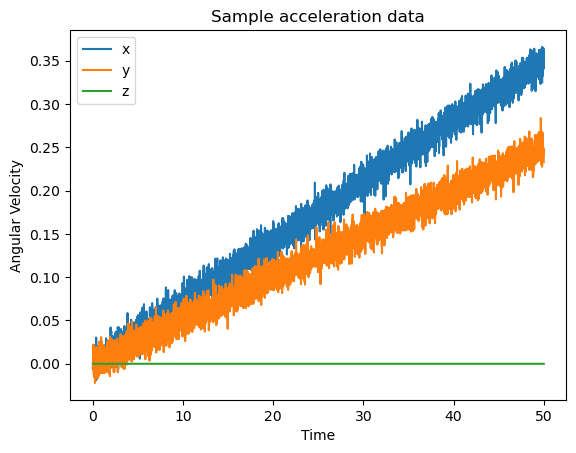

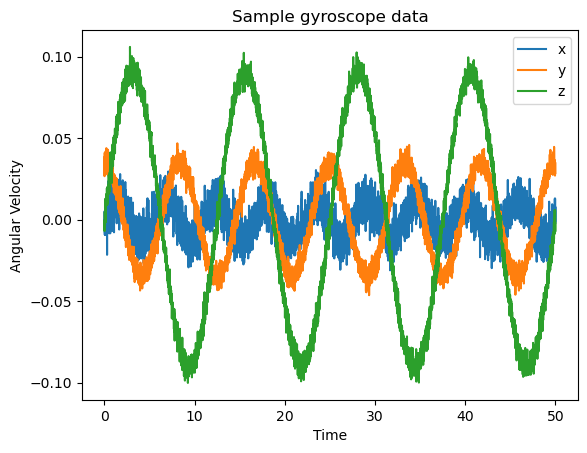

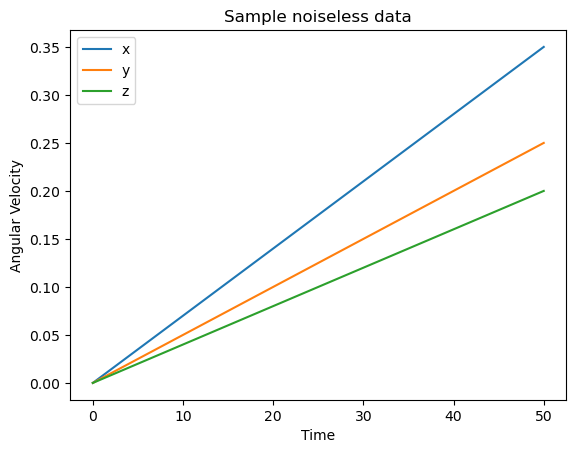

In [247]:
legend=['x','y','z']
Ydata=[accelMeasurements, gyroMeasurements,noNoiseMeasurements]
Titles = ['Sample acceleration data', 'Sample gyroscope data', 'Sample noiseless data']

for i in range(0,3):
    Plot(t,Ydata[i][0],'',' ',Titles[i],legend[0])
    Plot(t,Ydata[i][1],'',' ',Titles[i],legend[1])
    Plot(t,Ydata[i][2],'Time','Angular Velocity',Titles[i],legend[2])
    plt.show()

In [248]:
def Kalman(accel, gyro, NoNoise):
    xEst = [0 ,0 ,0]

    H=np.eye(3)
    P=np.eye(3)
    process_variance = 0.1; Q = (process_variance * np.eye(3)); 
    measurement_variance = 0.4; R = (measurement_variance * np.eye(3));
    
    filteredAngles = np.zeros((3,len(t)));
    noNoise = np.zeros((3,len(t)))
    noKalmanFilter = np.zeros((3,len(t)));
    
    for i in range(0,len(t)):
        
        RESULT = [[element * dt for element in sublist] for sublist in skew(gyro,i)]
        A = np.eye(3) + RESULT  #All fine up to here so far
        xPred = (np.dot(A,xEst)).reshape((3,1))
        errorCovariance = A*P*np.transpose(A) + Q
        
            #Update step 
        
        K = errorCovariance * np.transpose(H) / (H * errorCovariance * np.transpose(H) + R)
        eulerAngles = AccelToEuler(accel,i)
        residual = np.transpose(eulerAngles).reshape((3,1))  - np.dot(H,xPred)
        xEst = xPred + np.dot(np.nan_to_num(K), residual)
        P = (np.eye(3) - K * H) * errorCovariance
    
        NNeuler = AccelToEuler(NoNoise,i)
      
        for j in range(0,3):
            filteredAngles[j][i] = xEst[j]
            noKalmanFilter[j][i] = eulerAngles[j]
            NoNoise[j][i] = NNeuler[j]
        
    return RESULT, filteredAngles, noKalmanFilter, NoNoise

R, FA, NKF, NN = Kalman(accelMeasurements,gyroMeasurements,noNoiseMeasurements)

C:\Users\harve\AppData\Local\Temp\ipykernel_5272\2721388816.py:22: RuntimeWarning: invalid value encountered in true_divide
  K = errorCovariance * np.transpose(H) / (H * errorCovariance * np.transpose(H) + R)


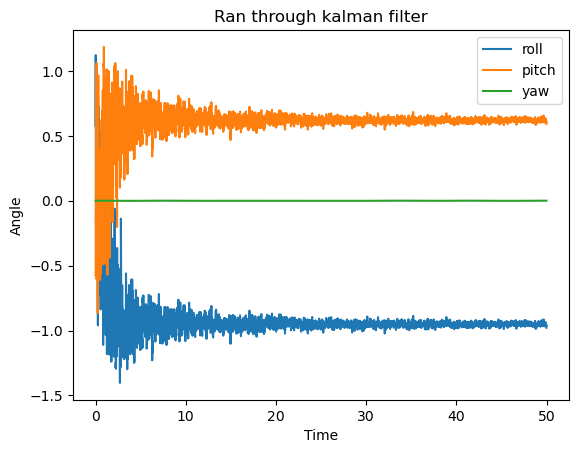

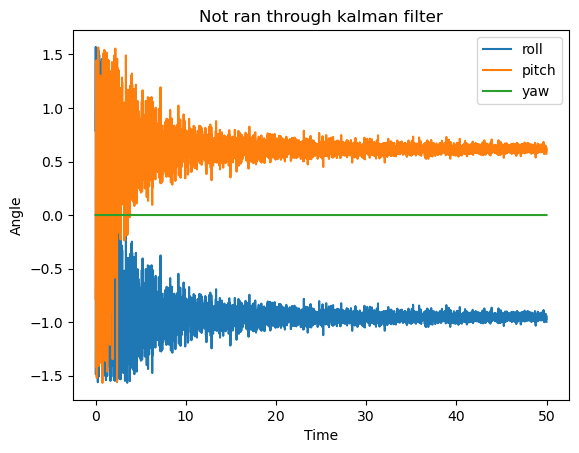

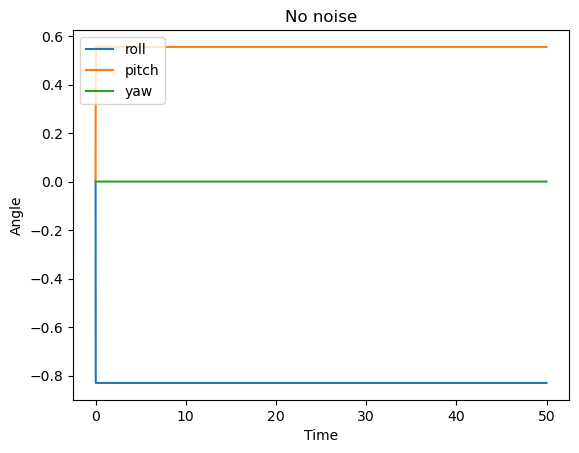

In [249]:
legend=['roll','pitch','yaw']
Ydata=[FA, NKF ,NN]
Titles = ['Ran through kalman filter', 'Not ran through kalman filter', 'No noise']

for i in range(0,3):
    Plot(t,Ydata[i][0],'',' ',Titles[i],legend[0])
    Plot(t,Ydata[i][1],'',' ',Titles[i],legend[1])
    Plot(t,Ydata[i][2],'Time','Angle',Titles[i],legend[2])
    plt.show()